In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Task 3 : Data Collection in the Wild**

### **Question 1**

Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform?

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Training data preparation

total_features = []
y = []

# Path to the directory containing training data
com_data_dir = "/content/drive/MyDrive/Task_2/Combined/Train"

# List of activities
activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

# Iterate over activities and subjects
for activity in activities:
    activity_dir = os.path.join(com_data_dir, activity)
    subject_files = [file for file in os.listdir(activity_dir) if file.endswith('.csv')]

    for file in subject_files:
        data_path = os.path.join(activity_dir, file)
        data = pd.read_csv(data_path)

        # Extract the accelerometer data
        acc_x = data['accx']
        acc_y = data['accy']
        acc_z = data['accz']

        df1 = pd.DataFrame({'accx': acc_x, 'accy': acc_y, 'accz': acc_z})
        total_features.append(df1)
        y.extend([activity] * len(df1))  # label for each row

# Combine into single DataFrame
combined_features = pd.concat(total_features, ignore_index=True)
combined_features.to_csv('training_data.csv', index=False)

y_df = pd.DataFrame(y, columns=['activity'])
y_df.to_csv("y_train.csv", index=False)



In [4]:
import os
print(os.listdir("/content/drive/MyDrive/Task_3/HAR_DATA"))


['STANDING', 'WALKING_DOWNSTAIRS', 'LAYING', 'SITTING', 'WALKING', 'WALKING_UPSTAIRS', '.ipynb_checkpoints']


In [5]:
# Test data preparation
test_features = []
y_test = []

com_test_dir = "/content/drive/MyDrive/Task_3/HAR_DATA"  # path to your TEST folder

for activity in activities:
    activity_dir = os.path.join(com_test_dir, activity)
    subject_files = [file for file in os.listdir(activity_dir) if file.endswith('.csv')]

    for file in subject_files:
        data_path = os.path.join(activity_dir, file)
        data = pd.read_csv(data_path)

        acc_x = data['gFx']
        acc_y = data['gFy']
        acc_z = data['gFz']

        df1 = pd.DataFrame({'accx': acc_x, 'accy': acc_y, 'accz': acc_z})
        test_features.append(df1)
        y_test.extend([activity] * len(df1))

X_test = pd.concat(test_features, ignore_index=True)
y_test = pd.Series(y_test, name='activity')


In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(combined_features)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Model training & evaluation
clf_model3 = DecisionTreeClassifier()
clf_model3.fit(X_train_scaled, y_df['activity'])

y_pred = clf_model3.predict(X_test_scaled)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.1668
Precision: 0.1153
Recall: 0.1668


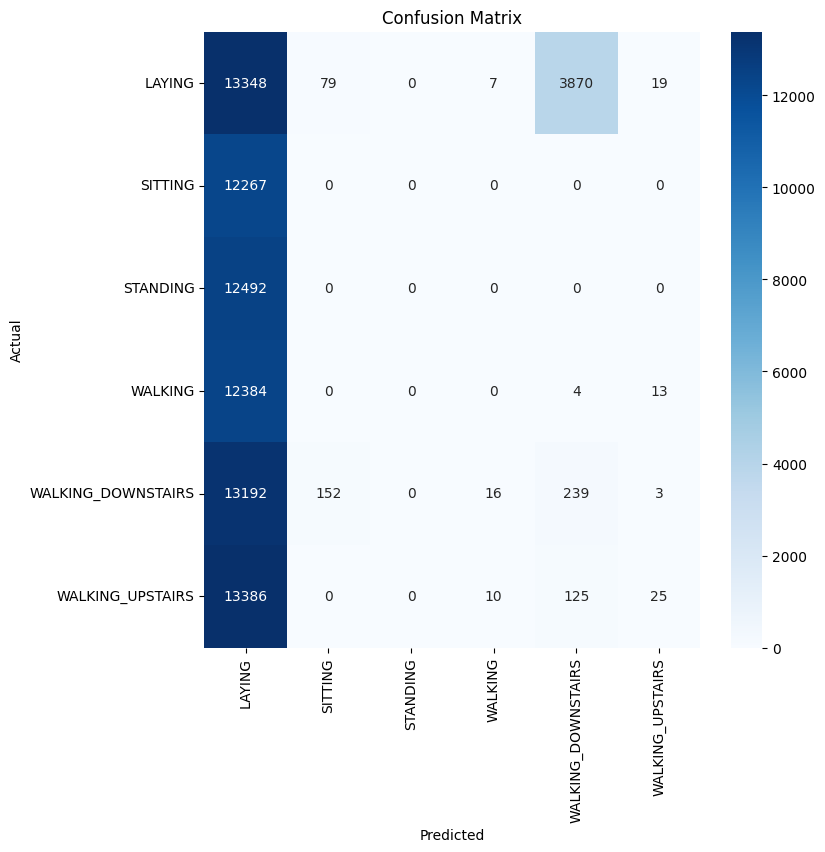

In [8]:
# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred, labels=activities)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Confusion Matrix plot
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

I am using the decisionTree Classification, but it is performing poorly on this test data, achieving only 16.4% accuracy. The confusion matrix shows that while the model could classify some LAYING instances correctly.It struggled significantly with almost all other activities.

For example, SITTING and STANDING were not recognized, and WALKING_UPSTAIRS was heavily confused with LAYING and WALKING_DOWNSTAIRS. The extremely low precision and recall indicate that the model failed to generalize to the given test data.

## **Question 2**


Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform?

In [11]:
import os
import numpy as np
import pandas as pd
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:

# Load dataset
base_dir = "/content/drive/MyDrive/Task_3/HAR_DATA"
all_data=[]
all_labels = []

for activity in os.listdir(base_dir):
    act_path = os.path.join(base_dir, activity)
    if os.path.isdir(act_path):
        for file in os.listdir(act_path):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(act_path, file))

                if 'time' in df.columns:
                    df = df.drop(columns=['time'])

                target_len = 2000
                data_resampled = resample(df.values, target_len, axis=0)
                all_data.append(data_resampled)
                all_labels.append(activity)


In [35]:

# Convert to numpy
X = np.array(all_data)
y = np.array(all_labels)

print("Raw dataset shape:", X.shape, y.shape)


def extract_features(sample, window_size=200):
    # Extract statistical features per window from a time-series sample
    features = []
    for start in range(0, sample.shape[0], window_size):
        window = sample[start:start+window_size, :]
        if len(window) == 0:
            continue
        # Stats per axis
        features.extend([
            np.mean(window, axis=0),
            np.std(window, axis=0),
            np.min(window, axis=0),
            np.max(window, axis=0),
        ])
    return np.concatenate(features)

X_features = np.array([extract_features(s) for s in X])
print("Feature matrix shape:", X_features.shape)


Raw dataset shape: (18, 2000, 3) (18,)
Feature matrix shape: (18, 120)


In [36]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


Accuracy: 0.5

Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         1
           SITTING       0.50      1.00      0.67         1
          STANDING       0.00      0.00      0.00         1
           WALKING       0.33      1.00      0.50         1
WALKING_DOWNSTAIRS       0.00      0.00      0.00         1
  WALKING_UPSTAIRS       0.00      0.00      0.00         1

          accuracy                           0.50         6
         macro avg       0.31      0.50      0.36         6
      weighted avg       0.31      0.50      0.36         6

X_train shape: (12, 120)
y_train shape: (12,)
X_test shape: (6, 120)
y_test shape: (6,)
X_train sample: [ 2.00510021 -2.24802858  1.36579911  1.92008923  0.5509064   1.93807114
  0.45218641 -1.23742797 -0.40386414  2.18406712 -0.75558704  2.1987965
  2.57409188 -2.76755405  2.28610339 -0.38578717  0.31029903 -0.23668517
  2.01848266 -2.02111992  1.96332414

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


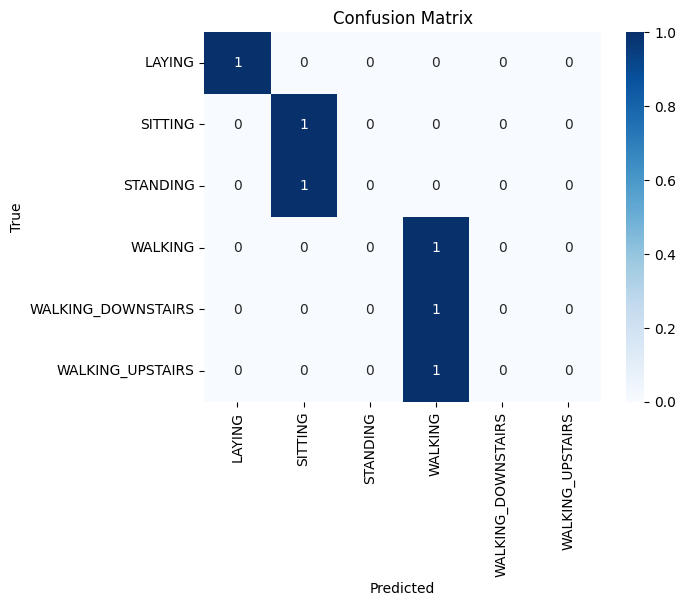

In [37]:
# Printting the Prediction
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("X_train sample:", X_train[3])
print("y_train sample:", y_train[3])
print("X_test sample:", X_test[3])
print("y_test sample:", y_test[3])

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**Observation:**

The model achieved an accuracy of 50%, with mixed results across different activities. Some activities such as LAYING and SITTING were predicted correctly, while others like STANDING, WALKING_DOWNSTAIRS, and WALKING_UPSTAIRS were not classified at all (precision and recall = 0).

May be the poor performance is mainly due to the small dataset size (only 18 samples total, with just 6 in the test set) and the limited generalization of a Decision Tree on such few samples.

**Conclusion:** This model will become mor accurate if we use more dataset. With a larger dataset, more robust preprocessing, or feature engineering, the performance would likely improve significantly.
